# DC2 Image Analysis, 511 keV, Image Deconvolution

updated on 2024-07-29 (the commit 14fc4c42f8b33749bd2053603643ca693dbc3954)

This notebook focuses on the image deconvolution with the spacecraft attitude (scatt) binning method for DC2.
Using the 511 keV thin disk 3-month simulation data created for DC2, an example of the image analysis will be presented.
If you have not run through 511keV-DC2-ScAtt-DataReduction.ipynb, please see it first.

In [1]:
import logging
import sys
logger = logging.getLogger('cosipy')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [3]:
from histpy import Histogram, HealpixAxis, Axis, Axes
from mhealpy import HealpixMap
from astropy.coordinates import SkyCoord, cartesian_to_spherical, Galactic

from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.ts_map.TSMap import TSMap
from cosipy.data_io import UnBinnedData, BinnedData
from cosipy.image_deconvolution import SpacecraftAttitudeExposureTable, CoordsysConversionMatrix, DataIF_COSI_DC2, ImageDeconvolution

# cosipy uses astropy units
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from threeML import *
from astromodels import Band

#Other standard libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 

import healpy as hp
from tqdm.autonotebook import tqdm

%matplotlib inline

## 0. Files needed for this notebook

From wasabi
- cosi-pipeline-public/COSI-SMEX/DC2/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5

From docs/tutorials/image_deconvolution/511keV/ScAttBinning
- inputs_511keV_DC2.yaml
- imagedeconvolution_parfile_scatt_511keV.yml

As outputs from the notebook 511keV-DC2-ScAtt-DataReduction.ipynb
- 511keV_scatt_binning_DC2_bkg.hdf5
- 511keV_scatt_binning_DC2_event.hdf5
- ccm.hdf5

## 1. Read the response matrix

<span style="color:red"> please modify "path_data" corresponding to your environment.</span>

In [4]:
path_data = "path/to/data/"

In [5]:
response_path = path_data + "SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5"

response = FullDetectorResponse.open(response_path)

In [6]:
response

FILENAME: '/Users/yoneda/Work/Exp/COSI/cosipy-2/data_challenge/DC2/prework/data/Responses/SMEXv12.511keV.HEALPixO4.binnedimaging.imagingresponse.nonsparse_nside16.area.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 3072
    NSIDE: 16
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 1
    EDGES: [509.0 keV, 513.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 1
    EDGES: [509.0 keV, 513.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 60
    EDGES: [0.0 deg, 3.0 deg, 6.0 deg, 9.0 deg, 12.0 deg, 15.0 deg, 18.0 deg, 21.0 deg, 24.0 deg, 27.0 deg, 30.0 deg, 33.0 deg, 36.0 deg, 39.0 deg, 42.0 deg, 45.0 deg, 48.0 deg, 51.0 deg, 54.0 deg, 57.0 deg, 60.0 deg, 63.0 deg, 66.0 deg, 69.0 deg, 72.0 deg, 75.0 deg, 78.0 deg, 81.0 deg, 84.0 deg, 87.0 deg, 90.0 deg, 93.0

## 2. Read binned 511keV binned files (source and background)

In [7]:
%%time

#  background 
data_bkg = BinnedData("inputs_511keV_DC2.yaml")
data_bkg.load_binned_data_from_hdf5("511keV_scatt_binning_DC2_bkg.hdf5")

##  signal + background
data_511keV = BinnedData("inputs_511keV_DC2.yaml")
data_511keV.load_binned_data_from_hdf5("511keV_scatt_binning_DC2_event.hdf5")

CPU times: user 148 ms, sys: 850 ms, total: 998 ms
Wall time: 1.01 s


## 3. Load the coordsys conversion matrix

In [8]:
%%time

ccm = CoordsysConversionMatrix.open("ccm.hdf5")

CPU times: user 1.5 s, sys: 71.3 ms, total: 1.57 s
Wall time: 1.58 s


## 4. Imaging deconvolution

### Brief overview of the image deconvolution

Basically, we have to maximize the following likelihood function

$$
\log L = \sum_i X_i \log \epsilon_i - \sum_i \epsilon_i
$$

$X_i$: detected counts at $i$-th bin ( $i$ : index of the Compton Data Space)

$\epsilon_i = \sum_j R_{ij} \lambda_j + b_i$ : expected counts ( $j$ : index of the model space)

$\lambda_j$ : the model map (basically gamma-ray flux at $j$-th pixel)

$b_i$ : the background at $i$-th bin

$R_{ij}$ : the response matrix

Since we have to optimize the flux in each pixel, and the number of parameters is large, we adopt an iterative approach to find a solution of the above equation. The simplest one is the ML-EM (Maximum Likelihood Expectation Maximization) algorithm. It is also known as the Richardson-Lucy algorithm.

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \delta \lambda_{j}^{k}
$$
$$
\delta \lambda_{j}^{k} = \frac{\lambda_{j}^{k}}{\sum_{i} R_{ij}} \sum_{i} \left(\frac{ X_{i} }{\epsilon_{i}} - 1 \right) R_{ij} 
$$

We refer to $\delta \lambda_{j}^{k}$ as the delta map.

As for now, the two improved algorithms are implemented in COSIpy.

- Accelerated ML-EM algorithm (Knoedlseder+99)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \delta \lambda_{j}^{k}
$$
$$
\alpha^{k} < \mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k})
$$

Practically, in order not to accelerate the algorithm excessively, we set the maximum value of $\alpha$ ($\alpha_{\mathrm{max}}$). Then, $\alpha$ is calculated as:

$$
\alpha^{k} = \mathrm{min}(\mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k}), \alpha_{\mathrm{max}})
$$

- Noise damping using gaussian smoothing (Knoedlseder+05, Siegert+20)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \left[ w_j \delta \lambda_{j}^{k} \right]_{\mathrm{gauss}}
$$
$$
w_j = \left(\sum_{i} R_{ij}\right)^\beta
$$

$\left[ ... \right]_{\mathrm{gauss}}$ means that the differential image is smoothed by a gaussian filter.

## 4-1. Prepare DataInterface containing all necessary datasets

In [10]:
%%time

data_interface = DataIF_COSI_DC2.load(name = "511keV",
                                      event_binned_data = data_511keV.binned_data,
                                      dict_bkg_binned_data = {"albedo": data_bkg.binned_data},
                                      rsp = response,
                                      coordsys_conv_matrix=ccm,
                                      is_miniDC2_format=False)

Loading the response matrix onto your computer memory...
Finished
Note that _modify_axes() in DataLoader was implemented for a temporary use. It will be removed in the future.
... checking the axis ScAtt of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Em of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Phi of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis PsiChi of the event and background files...
    --> pass (edges)
    --> pass (unit)
...checking the axis Em of the event and response files...
    --> pass (edges)
...checking the axis Phi of the event and response files...
    --> pass (edges)
...checking the axis PsiChi of the event and response files...
    --> pass (edges)
The axes in the event and background files are redefined. Now they are consistent with those of the response file.
Calculating an exposure map...
Finished...
C

### 4-2. Initialize the instance of the image deconvolution class

First, we prepare an instance of the ImageDeconvolution class and then register the dataset and parameters for the deconvolution. After that, you can start the calculation.

<span style="color:red"> please modify this parameter_filepath corresponding to your environment.</span>

In [34]:
parameter_filepath = "imagedeconvolution_parfile_scatt_511keV.yml"

In [35]:
image_deconvolution = ImageDeconvolution()

# set data_interface to image_deconvolution
image_deconvolution.set_dataset([data_interface])

# set a parameter file for the image deconvolution
image_deconvolution.read_parameterfile(parameter_filepath)

### Initialize image_deconvolution

In this process, a model map is defined following the input parameters, and it is initialized. Also, it prepares ancillary data for the image deconvolution, e.g., the expected counts with the initial model map, gaussian smoothing filter etc.

I describe parameters in the parameter file.

#### model_property

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| coordinate | str | the coordinate system of the model map | As for now, it must be 'galactic' |
| nside | int | NSIDE of the model map | it must be the same as NSIDE of 'lb' axis of the coordinate conversion matrix|
| scheme | str | SCHEME of the model map | As for now, it must be 'ring' |
| energy_edges | list of float [keV] | The definition of the energy bins of the model map | As for now, it must be the same as that of the response matrix |

#### model_initialization

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| algorithm | str | the method name to initialize the model map | As for now, only 'flat' can be used |
| parameter_flat:values | list of float [cm-2 s-1 sr-1] | the list of photon fluxes for each energy band | the length of the list should be the same as the length of "energy_edges" - 1 |

#### deconvolution

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
|algorithm | str | the name of the image deconvolution algorithm| As for now, only 'RL' is supported |
|||||
|parameter_RL:iteration | int | The maximum number of the iteration | |
|parameter_RL:acceleration | bool | whether the accelerated ML-EM algorithm (Knoedlseder+99) is used | |
|parameter_RL:alpha_max | float | the maximum value for the acceleration parameter | |
|parameter_RL:save_results_each_iteration | bool | whether an updated model map, detal map, likelihood etc. are saved at the end of each iteration | |
|parameter_RL:response_weighting | bool | whether a delta map is renormalized based on the exposure time on each pixel, namely $w_j = (\sum_{i} R_{ij})^{\beta}$ (see Knoedlseder+05, Siegert+20) | |
|parameter_RL:response_weighting_index | float | $\beta$ in the above equation | |
|parameter_RL:smoothing | bool | whether a Gaussian filter is used (see Knoedlseder+05, Siegert+20)  | |
|parameter_RL:smoothing_FWHM | float, degree | the FWHM of the Gaussian in the filter | |
|parameter_RL:background_normalization_fitting | bool | whether the background normalization factor is optimized at each iteration | As for now, the single background normalization factor is used in all of the bins |
|parameter_RL:background_normalization_range | list of float | the range of the normalization factor | should be positive |

In [36]:
image_deconvolution.initialize()

#### Initialization Starts ####
<< Instantiating the model class AllSkyImage >>
---- parameters ----
coordinate: galactic
energy_edges:
  unit: keV
  value:
  - 509.0
  - 513.0
nside: 16
scheme: ring
unit: cm-2 s-1 sr-1

<< Setting initial values of the created model object >>
---- parameters ----
algorithm: flat
parameter:
  unit: cm-2 s-1 sr-1
  value:
  - 1e-4

<< Registering the deconvolution algorithm >>
Gaussian filter with FWHM of 2.0 deg will be applied to delta images ...
---- parameters ----
algorithm: RL
parameter:
  acceleration: true
  alpha_max: 10.0
  background_normalization_optimization: true
  background_normalization_range:
    albedo:
    - 0.01
    - 10.0
  iteration_max: 10
  response_weighting: true
  response_weighting_index: 0.5
  save_results: false
  save_results_directory: ./results
  smoothing: true
  smoothing_FWHM:
    unit: deg
    value: 2.0

#### Initialization Finished ####


### (You can change the parameters as follows)

Note that when you modify the parameters, do not forget to run "initialize" again!

In [37]:
image_deconvolution.override_parameter("deconvolution:parameter:iteration_max = 30")
image_deconvolution.override_parameter("deconvolution:parameter:background_normalization_optimization = True")
image_deconvolution.override_parameter("deconvolution:parameter:alpha_max = 10")
image_deconvolution.override_parameter("deconvolution:parameter:smoothing_FWHM:value = 3.0")

image_deconvolution.initialize()

#### Initialization Starts ####
<< Instantiating the model class AllSkyImage >>
---- parameters ----
coordinate: galactic
energy_edges:
  unit: keV
  value:
  - 509.0
  - 513.0
nside: 16
scheme: ring
unit: cm-2 s-1 sr-1

<< Setting initial values of the created model object >>
---- parameters ----
algorithm: flat
parameter:
  unit: cm-2 s-1 sr-1
  value:
  - 1e-4

<< Registering the deconvolution algorithm >>
Gaussian filter with FWHM of 3.0 deg will be applied to delta images ...
---- parameters ----
algorithm: RL
parameter:
  acceleration: true
  alpha_max: 10
  background_normalization_optimization: true
  background_normalization_range:
    albedo:
    - 0.01
    - 10.0
  iteration_max: 30
  response_weighting: true
  response_weighting_index: 0.5
  save_results: false
  save_results_directory: ./results
  smoothing: true
  smoothing_FWHM:
    unit: deg
    value: 3.0

#### Initialization Finished ####


## 4-3. Start the image deconvolution

**With MacBook Pro with M1 Max and 64 GB memory, it takes about 6 minutes for 30 iterations.**

In [38]:
%%time

image_deconvolution.run_deconvolution()

#### Image Deconvolution Starts ####
<< Initialization >>
The response weighting filter was calculated.
The expected count histograms were calculated with the initial model map.


  0%|          | 0/30 [00:00<?, ?it/s]

## Iteration 1/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.1117259088539058
  background_normalization: {'albedo': 1.0050126418599168}
  loglikelihood: [-1551381.3046347937]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 2/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.4589369846150562
  background_normalization: {'albedo': 0.9959708325988547}
  loglikelihood: [-1512374.46901272]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 3/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 4.130808937204131
  background_normalization: {'albedo': 1.0012844690296692}
  loglikelihood: [-1509704.6551410041]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 4/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9962307721886375}
  loglikelihood: [-1493862.0484827922]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 5/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9994329904833922}
  loglikelihood: [-1492433.9595451895]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 6/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.6771693124541858
  background_normalization: {'albedo': 0.9998028740399162}
  loglikelihood: [-1490817.9922211317]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 7/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.449069075865903
  background_normalization: {'albedo': 0.9998675031710099}
  loglikelihood: [-1489842.2481823745]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 8/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998408770314386}
  loglikelihood: [-1489325.101495992]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 9/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998457175491627}
  loglikelihood: [-1488892.4039850137]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 10/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.99984625993385}
  loglikelihood: [-1488527.137553983]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 11/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998463424295027}
  loglikelihood: [-1488216.2200577823]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 12/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998464257441877}
  loglikelihood: [-1487949.4637732645]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 13/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998465535186982}
  loglikelihood: [-1487718.9020237564]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 14/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998467168565899}
  loglikelihood: [-1487518.2600785135]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 15/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998469023069589}
  loglikelihood: [-1487342.5363498037]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 16/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998471080648059}
  loglikelihood: [-1487187.7331807986]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 17/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998473246581261}
  loglikelihood: [-1487050.599753453]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 18/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998475565078137}
  loglikelihood: [-1486928.4722171663]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 19/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998478073767146}
  loglikelihood: [-1486819.1924637624]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 20/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998480657855443}
  loglikelihood: [-1486720.9625066128]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 21/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.999848334088258}
  loglikelihood: [-1486632.318098337]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 22/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998485984132034}
  loglikelihood: [-1486552.0271653645]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 23/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998488576362452}
  loglikelihood: [-1486479.030822393]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 24/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998491210871083}
  loglikelihood: [-1486412.4477046377]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 25/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998493834402365}
  loglikelihood: [-1486351.5230972534]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 26/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998496440561155}
  loglikelihood: [-1486295.6214640602]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 27/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998498967548999}
  loglikelihood: [-1486244.1778385974]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 28/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998501504408625}
  loglikelihood: [-1486196.7316539427]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 29/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998503876212085}
  loglikelihood: [-1486152.859412373]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 30/30 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 1.0
  background_normalization: {'albedo': 0.9998506246389144}
  loglikelihood: [-1486112.1990728814]
<< Checking Stopping Criteria >>
--> Stop
<< Finalization >>
#### Image Deconvolution Finished ####
CPU times: user 32min, sys: 2min 31s, total: 34min 31s
Wall time: 5min 2s


In [39]:
image_deconvolution.results

[{'iteration': 1,
  'model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xd89735840>,
  'delta_model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xd89736500>,
  'processed_delta_model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xd89735ab0>,
  'background_normalization': {'albedo': 1.0050126418599168},
  'alpha': <Quantity 2.11172591>,
  'loglikelihood': [-1551381.3046347937]},
 {'iteration': 2,
  'model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xd897364d0>,
  'delta_model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xd897350f0>,
  'processed_delta_model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xd89735270>,
  'background_normalization': {'albedo': 0.9959708325988547},
  'alpha': <Quantity 1.45893698>,
  'loglikelihood': [-1512374.46901272]},
 {'iteration': 3,
  'model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xd89734790>,
  'delta_model': <cosipy.image_

## 5. Analyze the results
Examples to see/analyze the results are shown below.

### Log-likelihood

Plotting the log-likelihood vs the number of iterations

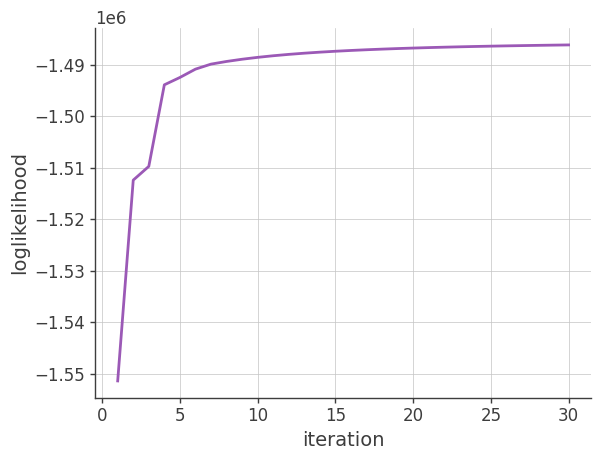

In [40]:
x, y = [], []

for result in image_deconvolution.results:
    x.append(result['iteration'])
    y.append(result['log-likelihood'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("log-likelihood")
plt.show()

### Alpha (the factor used for the acceleration)

Plotting $\alpha$ vs the number of iterations. $\alpha$ is a parameter to accelerate the EM algorithm (see the beginning of Section 4). If it is too large, reconstructed images may have artifacts.

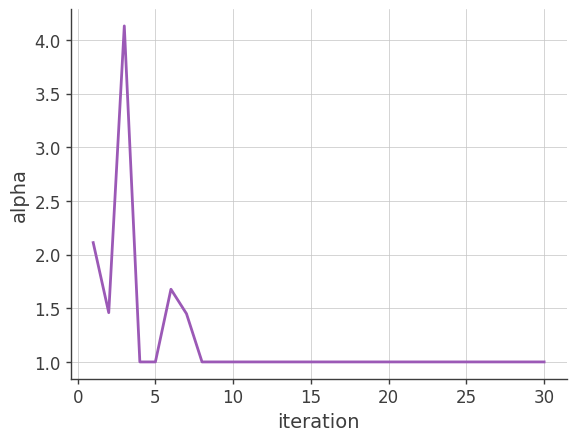

In [41]:
x, y = [], []

for result in image_deconvolution.results:
    x.append(result['iteration'])
    y.append(result['alpha'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("alpha")
plt.show()

### Background normalization

Plotting the background nomalization factor vs the number of iterations. If the background model is accurate and the image is reconstructed perfectly, this factor should be close to 1.

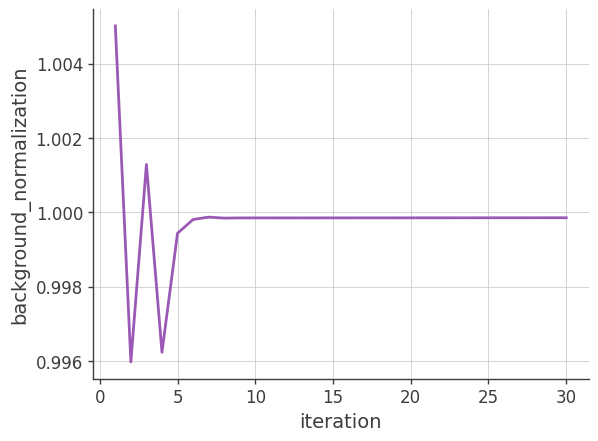

In [42]:
x, y = [], []

for result in image_deconvolution.results:
    x.append(result['iteration'])
    y.append(result['background_normalization']['albedo'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("background_normalization")
plt.show()

### The reconstructed images

In [43]:
def plot_reconstructed_image(result, source_position = None): # source_position should be (l,b) in degrees
    iteration = result['iteration']
    image = result['model']

    for energy_index in range(image.axes['Ei'].nbins):
        map_healpxmap = HealpixMap(data = image[:,energy_index], unit = image.unit)

        _, ax = map_healpxmap.plot('mollview')        
        
        _.colorbar.set_label(str(image.unit))
        
        if source_position is not None:
            ax.scatter(source_position[0]*u.deg, source_position[1]*u.deg, transform=ax.get_transform('world'), color = 'red')

        plt.title(label = f"iteration = {iteration}, energy_index = {energy_index} ({image.axes['Ei'].bounds[energy_index][0]}-{image.axes['Ei'].bounds[energy_index][1]})")

Plotting the reconstructed images in all of the energy bands at the 20th iteration

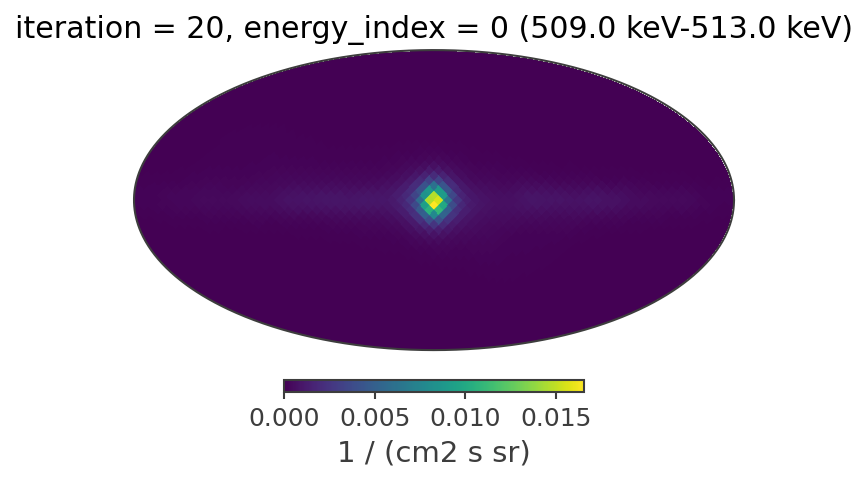

In [44]:
iteration = 19

plot_reconstructed_image(image_deconvolution.results[iteration])

An example to plot the image in the log scale

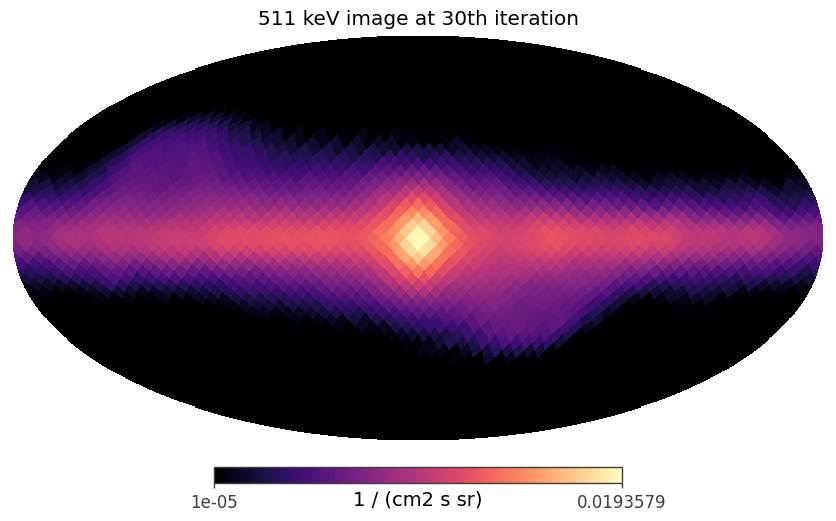

In [46]:
iteration_idx = 29

result = image_deconvolution.results[iteration_idx]

iteration = result['iteration']
image = result['model']

data = image[:,0]
data[data <= 0 * data.unit] = 1e-12 * data.unit

hp.mollview(data, min = 1e-5, norm ='log', unit = str(data.unit), title = f'511 keV image at {iteration}th iteration', cmap = 'magma')

plt.show()